In [31]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [103]:
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage
import os

import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow

import cv2

In [ ]:
import tensorflow.keras.applications as model_zoo

BaseModel = model_zoo.MobileNetV3Small(include_top=False,
                                        weights='imagenet',
                                        alpha=0.75,
                                        pooling="avg")
BaseModel.trainable = False # freeze pretrained weights
BaseModel.training=False # set to inference mode


In [32]:
rootDirPath = "/content/drive/MyDrive/CoronaryArtery"
defectPath = os.path.join(rootDirPath, "Defect")
normalPath = os.path.join(rootDirPath, "Ordinary")

In [34]:
image = Image.open(os.path.join(defectPath, "image_1.jpg"))
imageArray = np.array(image)
print(imageArray.shape)

(512, 512, 3)


In [35]:
imageArrayExpand = np.expand_dims(imageArray, axis=0)
embedding = BaseModel(imageArrayExpand, training=False)
print(embedding.shape)

(1, 432)


In [52]:
def CreateBinaryData():
  """
  1: class WITH coronary artery defects
  0: class WITH NO coronary artery defect
  """

  y_train = []
  x_train = []

  for pathTrue, pathFalse in zip(os.listdir(defectPath), os.listdir(normalPath)):

    imageTrue = np.array(Image.open(os.path.join(defectPath, pathTrue)))
    imageFalse = np.array(Image.open(os.path.join(normalPath, pathFalse)).convert("RGB"))

    imageTrue = np.expand_dims(imageTrue, axis=0)
    imageFalse = np.expand_dims(imageFalse, axis=0)

    imageTrue = BaseModel(imageTrue, training=False)[0]
    imageFalse = BaseModel(imageFalse, training=False)[0]

    x_train.append(imageTrue)
    x_train.append(imageFalse)

    y_train.append(1)
    y_train.append(0)

  x_train = np.array(x_train)
  y_train = np.array(y_train)

  return x_train, y_train

In [53]:
x_train, y_train = CreateBinaryData()

In [58]:
print(x_train.shape, y_train.shape)

(6, 432) (6,)


## BINARY CLASSIFICATION


In [61]:
BinaryClassificationModel = tf.keras.Sequential()
input_layer = tf.keras.layers.Input(shape=(432))
output_layer = tf.keras.layers.Dense(1, activation="sigmoid")
BinaryClassificationModel.add(input_layer)
BinaryClassificationModel.add(output_layer)
BinaryClassificationModel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [62]:
history = BinaryClassificationModel.fit(x_train, y_train, epochs=10)

Epoch 1/10
1/1 [==============================] - 0s 497ms/step - loss: 0.9723 - accuracy: 0.5000
Epoch 2/10
1/1 [==============================] - 0s 13ms/step - loss: 0.8730 - accuracy: 0.5000
Epoch 3/10
1/1 [==============================] - 0s 14ms/step - loss: 0.7838 - accuracy: 0.5000
Epoch 4/10
1/1 [==============================] - 0s 16ms/step - loss: 0.7060 - accuracy: 0.5000
Epoch 5/10
1/1 [==============================] - 0s 15ms/step - loss: 0.6408 - accuracy: 0.5000
Epoch 6/10
1/1 [==============================] - 0s 15ms/step - loss: 0.5883 - accuracy: 0.5000
Epoch 7/10
1/1 [==============================] - 0s 12ms/step - loss: 0.5478 - accuracy: 0.6667
Epoch 8/10
1/1 [==============================] - 0s 11ms/step - loss: 0.5177 - accuracy: 1.0000
Epoch 9/10
1/1 [==============================] - 0s 10ms/step - loss: 0.4958 - accuracy: 1.0000
Epoch 10/10
1/1 [==============================] - 0s 11ms/step - loss: 0.4797 - accuracy: 1.0000


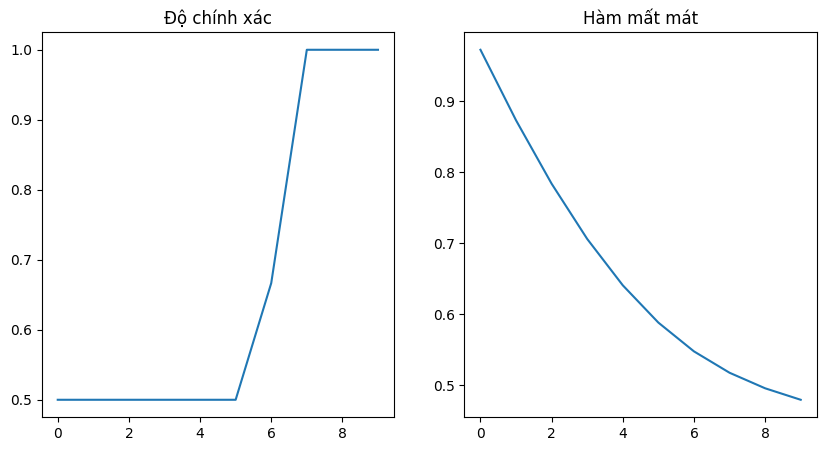

In [68]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].set_title("Độ chính xác")
axes[0].plot(history.history["accuracy"])
axes[1].set_title("Hàm mất mát")
axes[1].plot(history.history["loss"])

In [183]:
BinaryClassificationModel.save('/content/drive/MyDrive/BinaryClassificationModel.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [69]:
InferModel = tf.keras.Sequential()

InferModel.add(BaseModel)
InferModel.add(BinaryClassificationModel)

## BOUNDING BOX REGRESSION

In [167]:
def CreateDataForBBox():
  x_train_bbox = []
  y_train_bbox = []

  for pathTrue in os.listdir(defectPath):
    imageTrue = np.array(Image.open(os.path.join(defectPath, pathTrue)))
    imageTrue = np.expand_dims(imageTrue, axis=0)
    imageTrue = BaseModel(imageTrue, training=False)[0]

    x_train_bbox.append(imageTrue)

  # [ymin, xmin, ymax, xmax]
  y_load = np.load("/content/drive/MyDrive/BBoxCoordinates.npy")

  for i in range(y_load.shape[0]):
    for j in range(y_load.shape[1]):
      a = np.array(y_load[i][j])
      a *= 512
      a = np.round(a)
      print(a)
      y_train_bbox.append(a)

  x_train_bbox = np.array(x_train_bbox)
  y_train_bbox = np.array(y_train_bbox)

  return x_train_bbox, y_train_bbox

In [168]:
x_train_bbox, y_train_bbox = CreateDataForBBox()

print(x_train_bbox.shape, y_train_bbox.shape)

[220. 196. 255. 285.]
[199. 170. 240. 219.]
[198. 171. 250. 273.]
(3, 432) (3, 4)


In [169]:
ModelRegression = tf.keras.models.Sequential()
input_layer_reg = tf.keras.layers.Input(shape=(432))
output_layer_reg = tf.keras.layers.Dense(4, activation="linear")
ModelRegression.add(input_layer_reg)
ModelRegression.add(output_layer_reg)
# compile the model with an optimizer and loss function
ModelRegression.compile(optimizer='adam', loss='mae', metrics=['mse'])
ModelRegression.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 4)                 1732      
                                                                 
Total params: 1732 (6.77 KB)
Trainable params: 1732 (6.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [173]:
historyRegression = ModelRegression.fit(x_train_bbox, y_train_bbox, epochs=300)

Epoch 1/300
1/1 [==============================] - 0s 45ms/step - loss: 0.0212 - mse: 4.9167e-04
Epoch 2/300
1/1 [==============================] - 0s 29ms/step - loss: 0.0253 - mse: 6.6566e-04
Epoch 3/300
1/1 [==============================] - 0s 33ms/step - loss: 0.0263 - mse: 9.8805e-04
Epoch 4/300
1/1 [==============================] - 0s 50ms/step - loss: 0.0246 - mse: 7.2177e-04
Epoch 5/300
1/1 [==============================] - 0s 19ms/step - loss: 0.0267 - mse: 9.1758e-04
Epoch 6/300
1/1 [==============================] - 0s 22ms/step - loss: 0.0269 - mse: 8.2547e-04
Epoch 7/300
1/1 [==============================] - 0s 31ms/step - loss: 0.0128 - mse: 2.0777e-04
Epoch 8/300
1/1 [==============================] - 0s 23ms/step - loss: 0.0171 - mse: 4.3520e-04
Epoch 9/300
1/1 [==============================] - 0s 27ms/step - loss: 0.0228 - mse: 6.9094e-04
Epoch 10/300
1/1 [==============================] - 0s 37ms/step - loss: 0.0217 - mse: 5.8368e-04
Epoch 11/300
1/1 [===========

KeyError: ignored

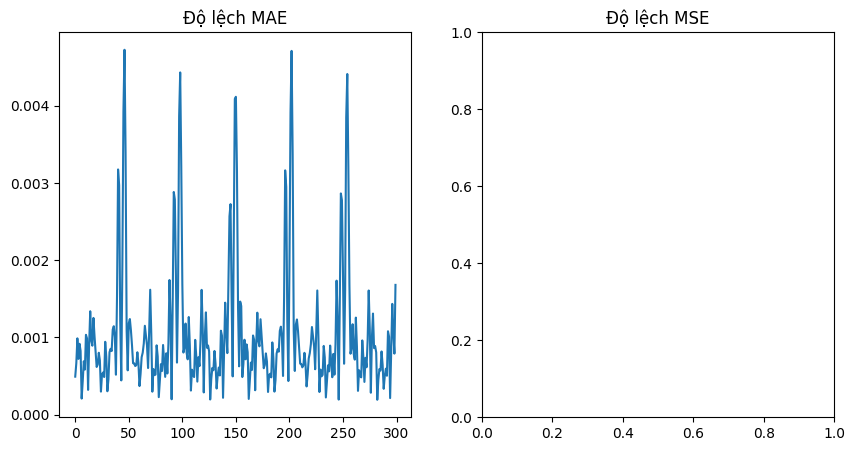

In [176]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].set_title("Độ lệch MAE")
axes[0].plot(historyRegression.history["mse"])
axes[1].set_title("Độ lệch MSE")
axes[1].plot(historyRegression.history["mae"])

In [177]:
RegressionModel = tf.keras.models.Sequential()
RegressionModel.add(BaseModel)
RegressionModel.add(ModelRegression)

In [178]:
image = cv2.imread(os.path.join(defectPath, "image_1.jpg"))
imageArray = np.array(image)
imageArrayExpand = np.expand_dims(imageArray, axis=0)
predictions = RegressionModel.predict(imageArrayExpand)

1/1 [==============================] - 1s 1s/step


In [179]:
predictions = np.array(predictions[0])
ymin, xmin, ymax, xmax = predictions
ymin = round(ymin)
xmin = round(xmin)
ymax = round(ymax)
xmax = round(xmax)

print(ymin, xmin, ymax, xmax)

220 196 255 285


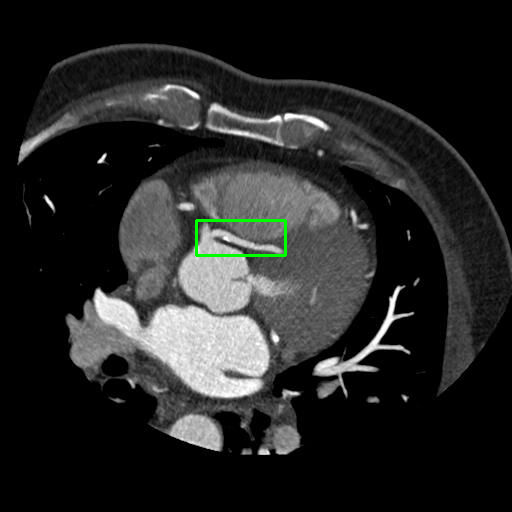

In [180]:
from google.colab.patches import cv2_imshow
cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

# Display the image with the bounding box
cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [182]:
ModelRegression.save("/content/drive/MyDrive/ModelRegression.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
